In [1]:
import cv2
from io import BytesIO
import ipywidgets
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
from picamera import PiCamera

In [2]:
img=cv2.imread('gerald-way-umbrella-academy-1.jpg')

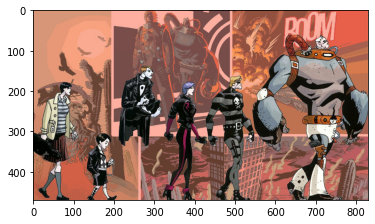

In [3]:
img_clr = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
plt.imshow(img_clr)

In [17]:
camera = PiCamera()
camera.resolution = (640,480)
camera.start_preview()

In [18]:
stream = BytesIO()
camera.capture(stream, format='jpeg')

In [19]:
stream.seek(0)
cam_img = cv2.imdecode(np.frombuffer(stream.read(), np.uint8), 1)
cam_img_clr = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGBA)

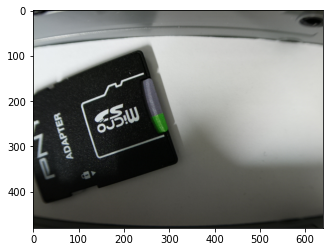

In [20]:
plt.imshow(cam_img_clr)

In [21]:
image_widget = ipywidgets.Image(format='jpeg')
image_widget.value = bytes(cv2.imencode('.jpg', cam_img_clr)[1])
display(image_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [57]:
def update_image():
    #stream = BytesIO()
    cam_img = np.empty((640*480*3,), dtype=np.uint8)
    camera.capture(cam_img, 'bgr')
    cam_img = cam_img.reshape((480,640,3))
    #stream.seek(0)
    #cam_img = cv2.imdecode(np.frombuffer(stream.read(), np.uint8), 1)
    #cam_img_clr = cv2.cvtColor(cam_img, cv2.COLOR_RGB2RGBA)
    image_widget.value = bytes(cv2.imencode('.jpg', cam_img)[1]) # can just do stream.read() here, but it's to show opencv an load it correctly

In [58]:
import threading
from time import sleep
running = True
def update_image_loop():
    while running:
        update_image()
        
t = threading.Thread(target=update_image_loop)
t.start()

In [59]:
running = False
t.join()

In [16]:
camera.stop_preview()
camera.close()

In [ ]:
# https://picamera.readthedocs.io/en/release-1.13/recipes2.html#rapid-capture-and-processing